# Tutorial 5

Students: Cristian Bassotto (s1148245), Roberta Chissich (s1148338)

In [3]:
from pypuf.simulation import ArbiterPUF, XORArbiterPUF
from pypuf.io import random_inputs
from pypuf.metrics import uniqueness
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def seed_from_string(student_id):
  return sum([int(c) for c in student_id])

# My student ID
student_id = "s1148245"
#student_id = "s1148338"

# Seed from every number in student ID
seed = seed_from_string(student_id[1:])
puf1 = ArbiterPUF(n=64, seed=seed, noisiness=0)

# Seed from last two digits of student ID
seed = seed_from_string(student_id[-2:])
puf2 = ArbiterPUF(n=64, seed=seed, noisiness=0)

# Generate challenges
challenges = random_inputs(n=64, N=10000, seed=7)

# Evaluate PUFs
resp1 = puf1.eval(challenges)
resp2 = puf2.eval(challenges)

def puf_hd(resp1, resp2):
  return sum(resp1 != resp2) / len(resp1)

# Calculate Normalized Hamming Distance
hd = puf_hd(resp1, resp2)
print(f"Normalized Hamming Distance: {hd}")

Normalized Hamming Distance: 0.5546


In [5]:
####################################################
#### Calculate the uniformity of the PUFs ##########
####################################################

def uniformity(resp):
  return (resp == 1).mean(), (resp == -1).mean()

# Calculate Uniformity
u1, u2 = uniformity(resp1)
print(f"Uniformity PUF 1: {u1}, {u2}")

u1, u2 = uniformity(resp2)
print(f"Uniformity PUF 2: {u1}, {u2}")

Uniformity PUF 1: 0.492, 0.508
Uniformity PUF 2: 0.4992, 0.5008


Uniqueness: [0.93256]


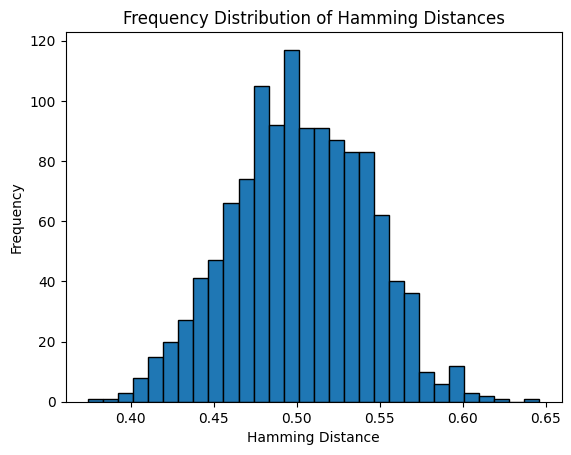

In [6]:
####################################################
#### Calculate the uniqueness of the PUFs ##########
####################################################

instances = [ArbiterPUF(n=64, seed=seed) for seed in range(5)]
uniqueness_value = uniqueness(instances, seed=31415, N=5000)
print(f"Uniqueness: {uniqueness_value}")

# Increase the number of instances to 50
instances = [ArbiterPUF(n=64, seed=seed) for seed in range(50)]
challenges = random_inputs(n=64, N=10000, seed=7)
responses = [instance.eval(challenges) for instance in instances]

# Compute HD between every pair of instances
def uniqueness_pairwise(responses):
  hd_values = []
  for i in range(len(responses)):
    for j in range(i + 1, len(responses)):
      hd = puf_hd(responses[i], responses[j])
      hd_values.append(hd)
  return hd_values

hd_values = uniqueness_pairwise(responses)

# Plot the frequency distribution (histogram) of the HDs
plt.hist(hd_values, bins=30, edgecolor='black')
plt.title('Frequency Distribution of Hamming Distances')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
#plt.savefig('frequency_distribution.png')
plt.show()

This is a Gaussian distribution.

In [7]:
####################################################
#### Calculate the average HD (relaiability) #######
####################################################

seed = seed_from_string(student_id[1:])

noisy_puf = ArbiterPUF(n=64, seed=seed, noisiness=0.1)
cha1 = random_inputs(n=64, N=20000, seed=7)

# Repeat the measurement 20 times for each challenge
repeated_responses = np.zeros((20, len(cha1)))

for i in range(20):
  repeated_responses[i] = noisy_puf.eval(cha1)

def majority_voting(responses):
  return np.sign(np.sum(responses, axis=0))

# Compute reference response using majority voting over the first 15 measurements
reference_response = majority_voting(repeated_responses[:15])

# Compute Hamming distance between the remaining 5 measurements and the reference response
hd_deployed = [puf_hd(reference_response, repeated_responses[i]) for i in range(15, 20)]

# Calculate the average HD for reliability
reliability_score = np.mean(hd_deployed)
print(f"Reliability Score: {reliability_score}")

Reliability Score: 0.04367


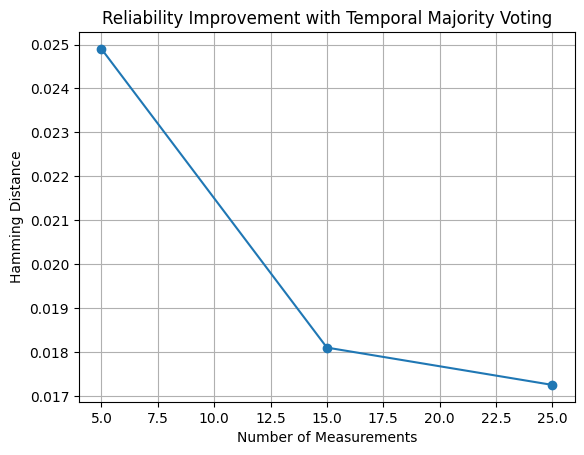

In [8]:
#####################################################
########### Temporal Majority Voting ################
#####################################################

# Re-generate responses for 5, 15, and 25 measurements
measurements = [5, 15, 25]
hd_temporal = []

for m in measurements:
  repeated_responses = np.zeros((m, len(cha1)))
  for i in range(m):
    repeated_responses[i] = noisy_puf.eval(cha1)
  
  # Compute majority-voted response
  majority_response = majority_voting(repeated_responses)
  
  # Compute Hamming distance from the reference response
  hd = puf_hd(reference_response, majority_response)
  hd_temporal.append(hd)

# Plot the HD to show how the reliability improves as the number of measurements increases
plt.figure()
plt.plot(measurements, hd_temporal, marker='o')
plt.title('Reliability Improvement with Temporal Majority Voting')
plt.xlabel('Number of Measurements')
plt.ylabel('Hamming Distance')
plt.grid(True)
#plt.savefig('temporal_majority_voting.png')
plt.show()

We can see the improvement over time, since that the Hamming distance is shortening (as shown by the drop on the graph).

In [9]:
####################################################
################ XOR Arbiter PUFs ##################
####################################################

# Generate XOR Arbiter PUFs
seed = seed_from_string(student_id[1:])

ks = [2, 4, 8]
num_instances = 10
noise_level = 0.1

for k in ks:
  print(f"\nSimulating {k}-XOR Arbiter PUFs")
  
  # Generate k-XOR Arbiter PUF instances
  xor_pufs = [XORArbiterPUF(n=64, k=k, seed=seed + i, noisiness=noise_level) for i in range(num_instances)]
  
  # Evaluate PUFs
  responses = [puf.eval(cha1) for puf in xor_pufs]
  
  # Calculate uniformity
  uniformities = [uniformity(resp) for resp in responses]
  u1_u2_mean = np.mean(uniformities, axis=0)
  print(f"Uniformity of {k}-XOR PUFs: {u1_u2_mean}")
  
  # Calculate uniqueness_pairwise
  uniqueness_value = np.mean(uniqueness_pairwise(responses))
  print(f"Uniqueness of {k}-XOR PUFs: {uniqueness_value}")
  
  # Calculate reliability
  noisy_puf = XORArbiterPUF(n=64, k=k, seed=seed, noisiness=noise_level)
  repeated_responses = np.zeros((20, len(cha1)))
  for i in range(20):
    repeated_responses[i] = noisy_puf.eval(cha1)
  
  reference_response = majority_voting(repeated_responses[:15])
  hd_deployed = [puf_hd(reference_response, repeated_responses[i]) for i in range(15, 20)]
  reliability_score = np.mean(hd_deployed)
  print(f"Reliability of {k}-XOR PUFs: {reliability_score}")


Simulating 2-XOR Arbiter PUFs
Uniformity of 2-XOR PUFs: [0.524155 0.475845]
Uniqueness of 2-XOR PUFs: 0.5005122222222224
Reliability of 2-XOR PUFs: 0.07573

Simulating 4-XOR Arbiter PUFs
Uniformity of 4-XOR PUFs: [0.49863 0.50137]
Uniqueness of 4-XOR PUFs: 0.5001777777777777
Reliability of 4-XOR PUFs: 0.13157999999999997

Simulating 8-XOR Arbiter PUFs
Uniformity of 8-XOR PUFs: [0.500245 0.499755]
Uniqueness of 8-XOR PUFs: 0.49954777777777776
Reliability of 8-XOR PUFs: 0.22381


There is some minor differences: the uniqueness values are more or less the same. The uniformity has slight variations, but they are all still close enough. In contrast, the reliability is worsening.